# High Lonesome 100 Cutoff Analysis

**Goal**: Evaluate the "fairness" of High Lonesome 100 cutoffs.
**Timeline**: Done in 2023 prior to 2023 running.

## Methodology

> How do we evaluate fairness scientifically?

For a given aid station, *AS1*: Consider the distribution of what time a runner got to AS1 vs their expected time to finish the course. Interpolate the aid station arrival time that corresponds to a 37-hour finish (the overall cutoff). Call that time the Point Of Unlikely Finish (`pouf`). Call the difference from the cutoff and the `pouf` to be the Cushion (or `cushion`).

I suppose then, that Cushion is an indicator of Fairness. A negative cushion means a cutoff is way to early. A high cushion means a cutoff is too lax. We can use this value to compare the aid stations. In particular, comparing the timeline of the aid stations should reveal outliers in the fairness (either one being too lenient or too strict).

> How do we calculate expected time of finishing?

Taking data from 2018-2022 (2017 data is known to be suspect.), we can line-fit an expected finish time to the data of time at aid station to finish time. We only consider those who finished in this line-fit because drops will skew the expectation.

## Step 1: Read in the data

In [225]:
## Read in data

from pathlib import Path
from csv import DictReader
import pandas as pd

data = []

for file in Path('../data').glob('*.csv'):
    year = int(file.name.split(' ')[0])
    print(f'Reading year: {year}')
    with file.open() as f:
        reader = DictReader(f)
        for d in reader:
            d['year'] = year
            data += [d]        
        
df = pd.DataFrame(data)
print(len(df))
df.head()

Reading year: 2019
Reading year: 2022
Reading year: 2021
410


,Overall rank,Gender rank,Bib number,First name,Last name,Gender,Age,State code,Country code,Flexible geolocation,...,Fooses Creek In,Fooses Creek Out,Blanks Cabin In,Blanks Cabin Out,Raspberry 2 In,Raspberry 2 Out,Finish,year,Shavano In,Shavano Out
0,1,1,48,Luke,Jay,male,38,CO,US,"Littleton, CO",...,16:43:00,16:44:00,18:53:25,18:55:39,21:04:22,21:05:56,22:22:43,2019,NaN,NaN
1,2,2,121,Mike,Wolfe,male,41,MT,US,"Bozeman, MT",...,16:43:00,16:45:00,19:00:57,19:02:57,21:28:49,21:32:15,23:15:52,2019,NaN,NaN
2,3,3,52,Zachary,King,male,33,CO,US,"Boulder, CO",...,17:16:02,17:21:08,19:27:00,19:36:00,21:50:20,21:52:48,23:23:13,2019,NaN,NaN
3,4,4,16,Patrick,Cole,male,38,CO,US,"Denver, CO",...,18:09:49,18:14:54,20:25:04,20:30:11,22:42:38,22:47:32,24:16:53,2019,NaN,NaN
4,5,5,51,Tyler,Keyworth,male,33,CO,US,"Denver, CO",...,18:15:11,18:16:14,20:32:46,20:43:06,23:07:01,23:14:06,24:57:45,2019,NaN,NaN


## Step 2: Input Aid Station Data

In [226]:
from typing import NamedTuple, Optional

def parse_elapsed_time(s: str) -> datetime.timedelta:
    if s: 
        hours, mins, seconds = s.split(':')
        return datetime.timedelta(hours=int(hours), minutes=int(mins), seconds=int(seconds))
    
def to_hours(td: datetime.timedelta) -> float:
    return td.days * 24 + td.seconds / 3600.

class AidStation(NamedTuple):
    name: str
    display_name: str
    distance: float
    cutoff: Optional[str] # elapsed time string
    
    def cutoff_hours(self):
        return to_hours(parse_elapsed_time(self.cutoff))
    
AIDS = [
    AidStation('rasp1', 'Raspberry 1', 7.3, '2:30:00'),
    AidStation('antero', 'Antero', 16.9, '7:00:00'),
    AidStation('stelmo1', 'St Elmo 1', 25.1, '9:30:00'),
    AidStation('cottonwood', 'Cottonwood', 31.3, '12:00:00'),
    AidStation('stelmo2', 'St Elmo 2', 37.5, '14:30:00'),
    AidStation('tincup', 'Tin Cup', 41.2, None),
    AidStation('hancock', 'Hancock', 49.3, '19:30:00'),
    AidStation('lwh', 'Lost Wonder', 55.7, '22:00:00'),
    AidStation('purg', 'Purgatory', 65.1, None),
    AidStation('monarch', 'Monarch Pass', 68.7, '27:00:00'),             
    AidStation('fooses', 'Fooses Creek', 75.7, '29:00:00'),
    AidStation('shavano', 'Shavano', 82.2, None),
    AidStation('blanks', 'Blanks Cabin', 84.1, '32:00:00'),
    AidStation('rasp2', 'Raspberry 2', 93.7, '34:45:00')
]

AIDS_WITH_CUTOFFS = [aid for aid in AIDS if aid.cutoff]

## Step 3: Reformat the data

The data is currently formatted as full race efforts. We want to format it as a row per aid station.

In [227]:
# Format needed columns
import datetime

df['finished'] = df['Finish'] != ''
df['finish_time'] = df['Finish'].map(parse_elapsed_time)

for aid in AIDS_WITH_CUTOFFS:
    df[aid.name] = df[f'{aid.display_name} Out'].map(parse_elapsed_time)

df.head()

,Overall rank,Gender rank,Bib number,First name,Last name,Gender,Age,State code,Country code,Flexible geolocation,...,antero,stelmo1,cottonwood,stelmo2,hancock,lwh,monarch,fooses,blanks,rasp2
0,1,1,48,Luke,Jay,male,38,CO,US,"Littleton, CO",...,0 days 03:16:14,0 days 04:36:27,0 days 06:11:33,0 days 07:44:57,0 days 10:28:40,0 days 12:05:55,0 days 15:33:49,0 days 16:44:00,0 days 18:55:39,0 days 21:05:56
1,2,2,121,Mike,Wolfe,male,41,MT,US,"Bozeman, MT",...,0 days 03:16:25,0 days 04:36:08,0 days 06:10:29,0 days 07:44:55,0 days 10:28:35,0 days 12:05:39,0 days 15:34:52,0 days 16:45:00,0 days 19:02:57,0 days 21:32:15
2,3,3,52,Zachary,King,male,33,CO,US,"Boulder, CO",...,0 days 03:21:18,0 days 04:49:58,0 days 06:23:38,0 days 07:57:38,0 days 10:51:45,0 days 12:27:04,0 days 15:58:28,0 days 17:21:08,0 days 19:36:00,0 days 21:52:48
3,4,4,16,Patrick,Cole,male,38,CO,US,"Denver, CO",...,0 days 03:39:31,0 days 05:05:33,0 days 07:02:32,0 days 08:38:01,0 days 11:28:48,0 days 13:05:14,0 days 16:36:54,0 days 18:14:54,0 days 20:30:11,0 days 22:47:32
4,5,5,51,Tyler,Keyworth,male,33,CO,US,"Denver, CO",...,0 days 03:36:02,0 days 05:00:51,0 days 06:43:37,0 days 08:27:05,0 days 11:21:48,0 days 13:01:00,0 days 16:53:36,0 days 18:16:14,0 days 20:43:06,0 days 23:14:06


In [228]:
# Reformat by exploding aid stations

def combine_aids(row):
    return [
        {'aid': aid.name, 'time': row[aid.name]}
        for aid in AIDS_WITH_CUTOFFS
    ]

df['aids'] = df.apply(combine_aids, axis=1)

df1 = df.explode('aids')
df1['aid'] = df1.aids.map(lambda aids: aids['aid'])
df1['time'] = df1.aids.map(lambda aids: aids['time'])
df1['distance'] = df1.aid.map(lambda aid: [a.distance for a in AIDS if a.name == aid][0])
df1 = df1[['finished', 'finish_time', 'aid', 'time', 'distance']]

df1['norm_finish_time'] = df1.finish_time.map(lambda ft: datetime.timedelta(hours=40) if pd.isnull(ft) else ft)
df1['norm_finish_time_hours'] = df1.norm_finish_time.map(to_hours)
df1['norm_finished'] = df1.finished.map(lambda f: 1 if f else 0)
df1['norm_not_finished'] = df1.finished.map(lambda f: 0 if f else 1)
df1['time_hours'] = df1.time.map(to_hours)
df1.head()

,finished,finish_time,aid,time,distance,norm_finish_time,norm_finish_time_hours,norm_finished,norm_not_finished,time_hours
0,True,0 days 22:22:43,rasp1,0 days 01:05:52,7.3,0 days 22:22:43,22.378611,1,0,1.097778
0,True,0 days 22:22:43,antero,0 days 03:16:14,16.9,0 days 22:22:43,22.378611,1,0,3.270556
0,True,0 days 22:22:43,stelmo1,0 days 04:36:27,25.1,0 days 22:22:43,22.378611,1,0,4.607500
0,True,0 days 22:22:43,cottonwood,0 days 06:11:33,31.3,0 days 22:22:43,22.378611,1,0,6.192500
0,True,0 days 22:22:43,stelmo2,0 days 07:44:57,37.5,0 days 22:22:43,22.378611,1,0,7.749167


In [233]:
# Clean up outliers

# Remove anyone who comes in over 2 hours after cutoff from any aid station
print(f'Before cleaning, we have {len(df1)} efforts')
df2 = df1
for aid in AIDS_WITH_CUTOFFS:
    df2 = df2[(df2.aid != aid.name) | (df2.time_hours <= aid.cutoff_hours() + 2)]
    
print(f'After cleaning, we have {len(df2)} efforts')

Before cleaning, we have 4510 efforts
After cleaning, we have 3831 efforts


## Step 4: Find POUFs

First, line-fit an estimated finish time function. Then calculate `pouf` and `cushion` for each aid.

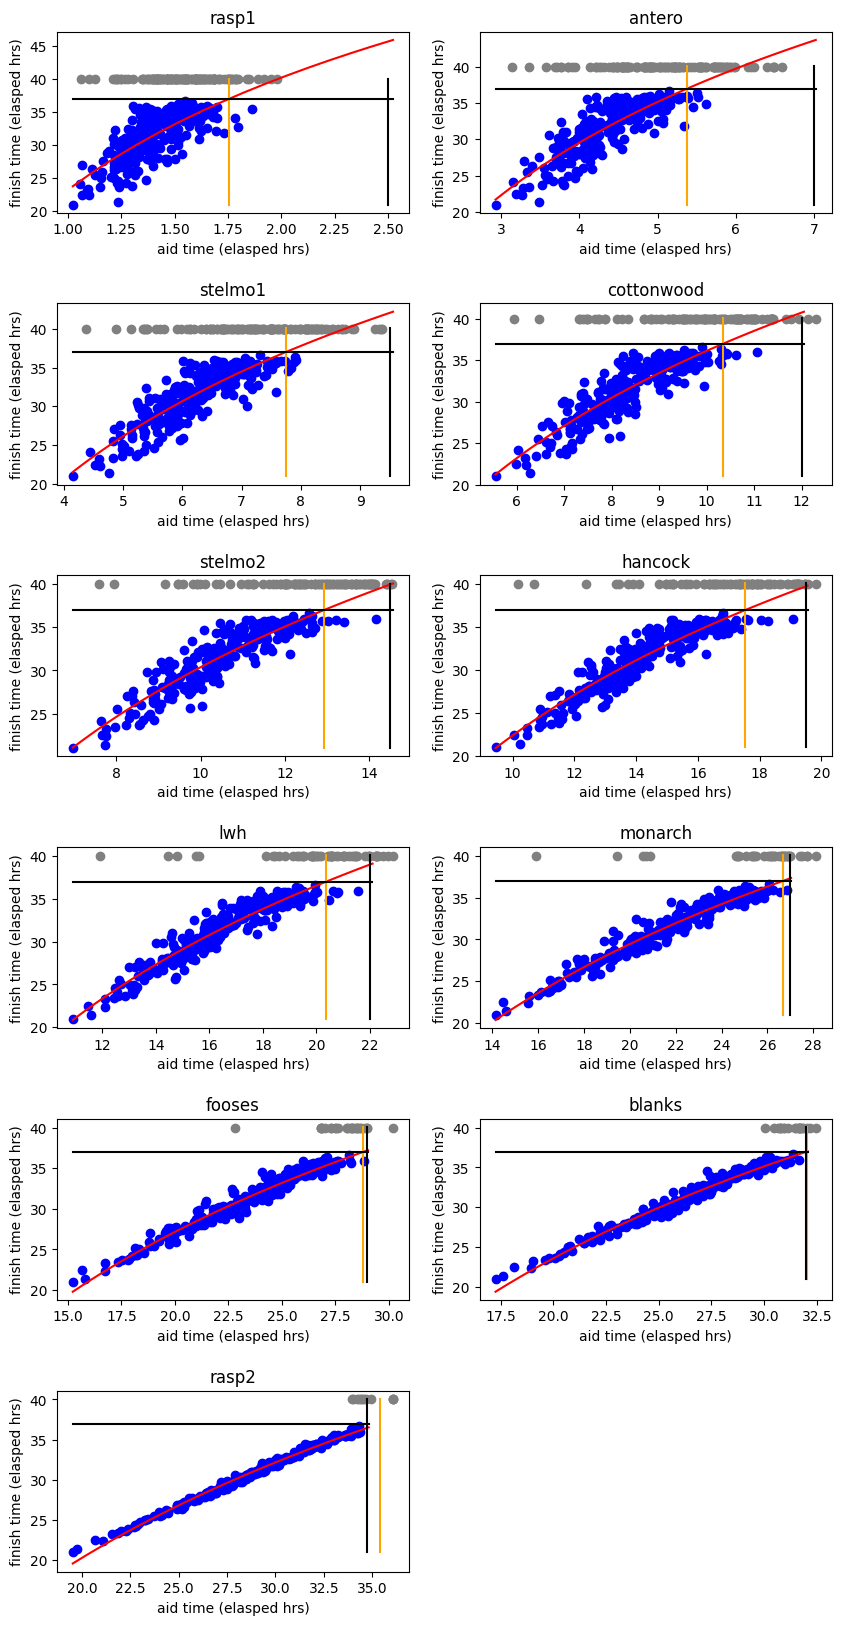

,display_name,distance,cutoff,cutoff_hours,pouf,cushion_hours,cushion
name,,,,,,,
rasp1,Raspberry 1,7.3,2:30:00,2.50,1.752835,0.747165,0 days 00:44:49.792304
antero,Antero,16.9,7:00:00,7.00,5.380298,1.619702,0 days 01:37:10.926491
stelmo1,St Elmo 1,25.1,9:30:00,9.50,7.749045,1.750955,0 days 01:45:03.437030
cottonwood,Cottonwood,31.3,12:00:00,12.00,10.348579,1.651421,0 days 01:39:05.115035
stelmo2,St Elmo 2,37.5,14:30:00,14.50,12.924405,1.575595,0 days 01:34:32.143171
hancock,Hancock,49.3,19:30:00,19.50,17.540719,1.959281,0 days 01:57:33.411849
lwh,Lost Wonder,55.7,22:00:00,22.00,20.360630,1.639370,0 days 01:38:21.732281
monarch,Monarch Pass,68.7,27:00:00,27.00,26.671126,0.328874,0 days 00:19:43.945326
fooses,Fooses Creek,75.7,29:00:00,29.00,28.790198,0.209802,0 days 00:12:35.287550


In [261]:
import scipy.optimize
import scipy.stats
import matplotlib.pyplot as plt

FINISH_CUTOFF = 37

# square polynomial function
# f = lambda x, c0, c1, c2: c0 + x*c1 + x*x*c2
f = lambda x, a, b: a + b * np.log(x)

def exp_finish_time_line_fit(df):
    return 
    
def find_pouf(aid, charti=None):
    adf = df2[df2.aid == aid.name]
    adf = adf[~pd.isnull(adf.time)].sort_values('time_hours')
    
    adf_finished = adf[adf.finished]
    adf_dropped = adf[~adf.finished]
        
    params = scipy.optimize.curve_fit(f, adf_finished.time_hours, adf_finished.norm_finish_time_hours)[0]
    
    pouf = np.interp(FINISH_CUTOFF, adf.time_hours.map(lambda x: f(x, *params)), adf.time_hours)

    if charti:
        ax = plt.subplot(6,2,charti, label=aid.name)
        ax.margins(0.05)
        ax.set_title(aid.name)
        ax.set_xlabel('aid time (elasped hrs)')
        ax.set_ylabel('finish time (elasped hrs)')
        ax.scatter(adf_dropped.time_hours, adf_dropped.norm_finish_time_hours, color='grey')
        ax.scatter(adf_finished.time_hours, adf_finished.norm_finish_time_hours, color='blue')
        

        time0 = adf.time_hours.min()
        time1 = aid.cutoff_hours()
        finish_time0 = adf.norm_finish_time_hours.min()
        finish_time1 = 40
        
        times = np.arange(time0, time1+0.1, step=0.1)
        finish_times = np.arange(finish_time0, finish_time1+0.1, step=0.1)
        
        ax.plot(times, pd.Series(times).map(lambda x: f(x, *params)).map(lambda x: max(x,0)), color = 'red')
        ax.plot(finish_times*0+pouf, finish_times, color='orange')
        ax.plot(finish_times*0+aid.cutoff_hours(),finish_times, color='black')
        ax.plot(times, times*0+FINISH_CUTOFF, color='black')
    
    return pouf

plt.figure(figsize=(10,20))

dfaids = pd.DataFrame(AIDS_WITH_CUTOFFS)
dfaids = dfaids.set_index('name')
dfaids['cutoff_hours'] = dfaids.cutoff.map(lambda t: to_hours(parse_elapsed_time(t)))
poufs = [find_pouf(aid, charti=i+1) for i, aid in enumerate(AIDS_WITH_CUTOFFS)]
dfaids['pouf'] = poufs
dfaids['cushion_hours'] = dfaids.cutoff_hours - dfaids.pouf
dfaids['cushion'] = dfaids.cushion_hours.map(lambda hrs: datetime.timedelta(hours=hrs))

plt.subplots_adjust(hspace=0.5)
plt.show()

dfaids

## Step 5: Chart results by Aids

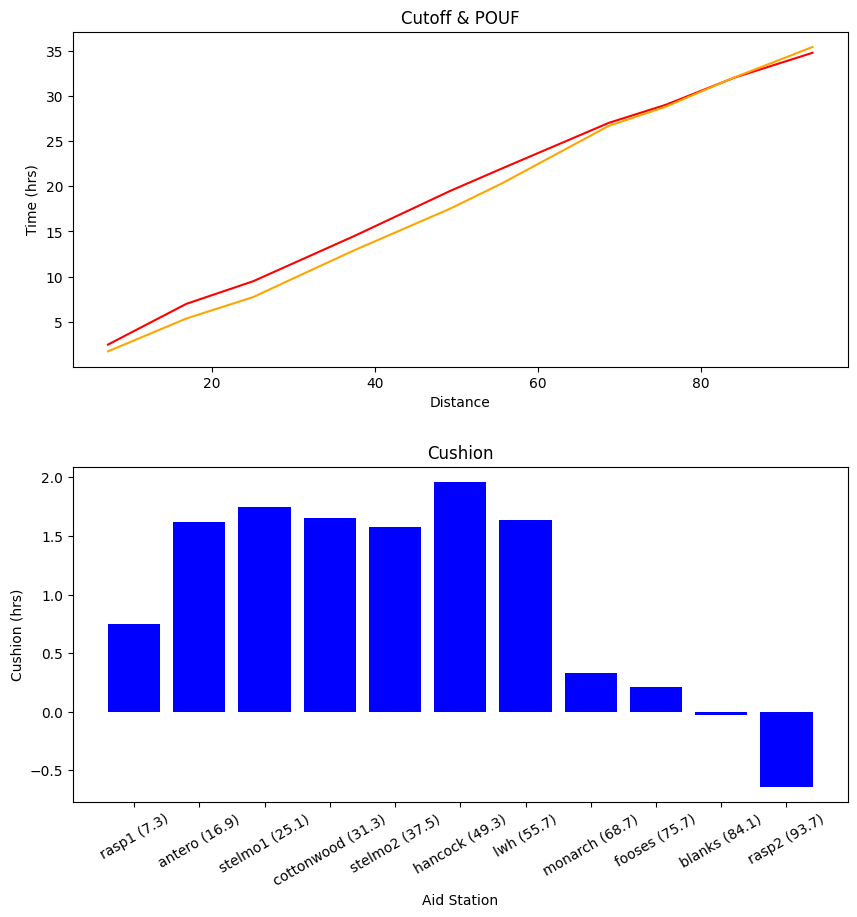

In [264]:

plt.figure(figsize=(10,10))
ax1 = plt.subplot(2,1,1)

ax1.set_title('Cutoff & POUF')
ax1.set_xlabel('Distance')
ax1.set_ylabel('Time (hrs)')
ax1.plot(dfaids.distance, dfaids.cutoff_hours, color='red', label='cutoff')
ax1.plot(dfaids.distance, dfaids.pouf, color='orange', label='pouf')

ax2 = plt.subplot(2,1,2)

ax2.set_title('Cushion')
ax2.set_xlabel('Aid Station')
ax2.set_ylabel('Cushion (hrs)')
ax2.bar(dfaids.apply(lambda row: f'{row.name} ({row.distance})', axis=1), 
        dfaids.cushion_hours, color='blue', label='cushion')
plt.xticks(rotation=30)

plt.subplots_adjust(hspace=0.3)
plt.show()

# Conclusions

## Lost Wonder to Monarch is the strictest change in Cushion

In travelling from Lost Wonder to Monarch, the cushion drops dramatically from 1h38m at Lost Wonder to just under 20m at Monarch, for a drop of about 1h20m. This essentially means that if you're travelling at an expected 36 hour finish, you will be well under the LWH cutoff, but will be very close to the Monarch cutoff.

As some more evidence of this fact, I used the [OpenSplitTime "Plan My Effort" feature](https://www.opensplittime.org/organizations/freestone-endurance/courses/high-lonesome-100/plan_effort?start_time=07%2F21%2F2023+06%3A00%3A00&expected_time=36%3A00&button=) to estimate the aid station times for a 37 hour effort, based on past efforts. The Lost Wonder Out time is 19:49, or 2h11m shy of the cutoff. The Monarch Out time is 26:02, only 58m shy of the cutoff!



## Raspberry 2 is too strict for the new 37 hour cutoff

In 2023, the overall cutoff was changed from 36 to 37 hours, without changing any of the aid station cutoff times. This essentially gives anyone who gets past the original Raspberry 2 cutoff a near-100% chance of finishing in time. 

However, this analysis does indicate that now with the 37 hour overall cutoff, the Raspberry 2 cutoff is roughly 40m too strict, as some runners would be able to make it to a 37 hour finish without making the 34:45 Raspberry 2 finish. 

## Cutoff Change Suggestions

I believe that the cushion chart should be high for the first half of the race, then consistently approach 0 as it reaches the end of the race. This allows early runners more time to recover from a bad day and clears the course of runners who will not make the finish cutoff consistently.

**Note**: These suggestions assume a cutoff cushion that is designed to linearly approach 0. However, this is an arguable point. One might argue that a single "hard" cutoff at Monarch is the appropriate design.

I suggest that Monarch's cutoff be extended by 30m to 1h. This still reduces the cushion from the Collegiate West Aid Stations, but does it more gradually. Similarly, Fooses should be extended by 15m to 30m, and Blanks by 15m. This would make the cushion chart _gradually_ approach 0 as you approach the end of the race.

Finally, I think it would be reasonable to extend Raspberry 2's cutoff from 34:45 to 35 hours or 35:15, which may allow a couple back-of-packers every year to snag a 37-hour finish.

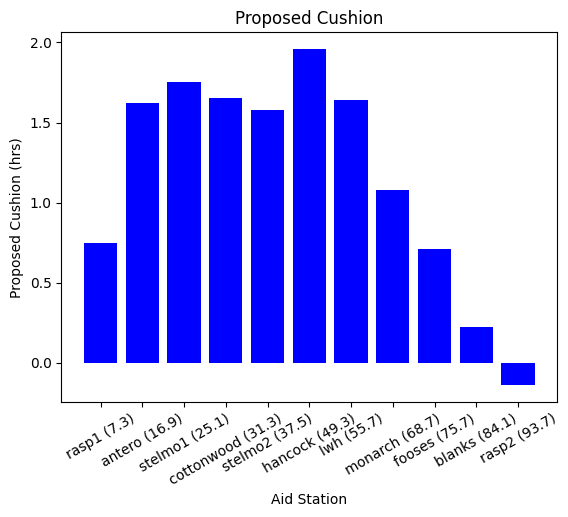

,display_name,distance,cutoff,cutoff_hours,pouf,cushion_hours,cushion,proposed_cutoff_hours,proposed_cushion_hours
name,,,,,,,,,
rasp1,Raspberry 1,7.3,2:30:00,2.50,1.752835,0.747165,0 days 00:44:49.792304,2.50,0.747165
antero,Antero,16.9,7:00:00,7.00,5.380298,1.619702,0 days 01:37:10.926491,7.00,1.619702
stelmo1,St Elmo 1,25.1,9:30:00,9.50,7.749045,1.750955,0 days 01:45:03.437030,9.50,1.750955
cottonwood,Cottonwood,31.3,12:00:00,12.00,10.348579,1.651421,0 days 01:39:05.115035,12.00,1.651421
stelmo2,St Elmo 2,37.5,14:30:00,14.50,12.924405,1.575595,0 days 01:34:32.143171,14.50,1.575595
hancock,Hancock,49.3,19:30:00,19.50,17.540719,1.959281,0 days 01:57:33.411849,19.50,1.959281
lwh,Lost Wonder,55.7,22:00:00,22.00,20.360630,1.639370,0 days 01:38:21.732281,22.00,1.639370
monarch,Monarch Pass,68.7,27:00:00,27.00,26.671126,0.328874,0 days 00:19:43.945326,27.75,1.078874
fooses,Fooses Creek,75.7,29:00:00,29.00,28.790198,0.209802,0 days 00:12:35.287550,29.50,0.709802


In [269]:
dfaids['proposed_cutoff_hours'] = dfaids.cutoff_hours
dfaids.at['monarch', 'proposed_cutoff_hours'] = dfaids.at['monarch', 'cutoff_hours'] + 0.75 #45m
dfaids.at['fooses', 'proposed_cutoff_hours'] = dfaids.at['fooses', 'cutoff_hours'] + 0.5 #30m
dfaids.at['blanks', 'proposed_cutoff_hours'] = dfaids.at['blanks', 'cutoff_hours'] + 0.25 #15m
dfaids.at['rasp2', 'proposed_cutoff_hours'] = dfaids.at['rasp2', 'cutoff_hours'] + 0.5 #30m

dfaids['proposed_cushion_hours'] = dfaids.proposed_cutoff_hours - dfaids.pouf

ax1 = plt.subplot(1,1,1)

ax1.set_title('Proposed Cushion')
ax1.set_xlabel('Aid Station')
ax1.set_ylabel('Proposed Cushion (hrs)')
ax1.bar(dfaids.apply(lambda row: f'{row.name} ({row.distance})', axis=1), 
        dfaids.proposed_cushion_hours, color='blue', label='cushion')
plt.xticks(rotation=30)

plt.show()

dfaids